In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from tsfm_public.models.tspulse.modeling_tspulse import TSPulseForReconstruction
from tsfm_public.toolkit.time_series_anomaly_detection_pipeline import (
    AnomalyPredictionModes,
    TimeSeriesAnomalyDetectionPipeline,
)

# Example Datafile

Data instance from IOPS dataset ([Paper](https://arxiv.org/html/2402.10802v1)). The data example is a part of the IOPS dataset.

The IOPS data set is an anonymized dataset with performance indicators that reflect the scale, quality of web services, and health status of a machine.



In [2]:
data_path = "https://huggingface.co/datasets/AutonLab/Timeseries-PILE/resolve/main/anomaly_detection/TSB-UAD-Public/IOPS/KPI-4d2af31a-9916-3d9f-8a8e-8a268a48c095.test.out"


## Helper Functions for Data Loading and Processing

`load_data` loads the large dataset in chunks.

`attach_timestamp_column` current pipeline expects a timestamp column in the input. The IOPS dataset does not have an explicit time column specified. This helper function attach a dummy timestamp column to the dataset.



In [3]:
def load_data(file_path: str, max_length: int, min_length: int):
    data = []
    extra_args = {}
    if file_path.endswith("gz"):
        extra_args["compression"] = "gzip"
    for chunk in pd.read_csv(file_path, header=None, sep=",", chunksize=max_length, *extra_args):
        if (chunk is None) or (chunk.ndim != 2):
            break
        chunk.columns = ["x", "y"]
        chunk["x"] = chunk.x.interpolate(method="cubic").ffill().bfill()
        chunk["y"] = chunk.y.ffill().bfill()
        if chunk.shape[0] > min_length:
            data.append(chunk)
        elif len(data) > 0:
            data[-1] = pd.concat([data[-1], chunk], axis=0)
    return data


def attach_timestamp_column(
    df: pd.DataFrame, time_col: str = "timestamp", freq: str = "D", start_date: str = "2022-01-01"
):
    n = df.shape[0]
    if time_col not in df:
        df[time_col] = pd.date_range(start_date, freq=freq, periods=n)
    return df

In [4]:
max_length, min_length = 5_000, 2_000

data = load_data(data_path, max_length, min_length)

## Loading ZeroShort TSPulseReconstruction Model

In [5]:
zeroshot_model = TSPulseForReconstruction.from_pretrained(
    "/Users/sumanta/Documents/External/model/tspulse_consistent_masking_var_hybrid_e20_scaled",
    num_input_channels=1,
    scaling="revin",
    mask_type="user",
)

## Instantiating pipeline

In [6]:
pipeline = TimeSeriesAnomalyDetectionPipeline(
    zeroshot_model,
    timestamp_column="timestamp",
    target_columns=["x"],
    prediction_mode=AnomalyPredictionModes.PREDICTIVE_WITH_IMPUTATION.value,
    aggr_win_size=64,
    aggr_function="max",
    smoothing_window_size=16,
)

Device set to use mps:0


In [7]:
df_input = attach_timestamp_column(data[10], time_col="timestamp", freq="s")
df_input.head()

,x,y,timestamp
50000,5.00,0,2022-01-01 00:00:00
50001,4.80,0,2022-01-01 00:00:01
50002,5.25,0,2022-01-01 00:00:02
50003,4.95,0,2022-01-01 00:00:03
50004,5.05,0,2022-01-01 00:00:04


## Computing Anomaly Score With Anomaly Pipeline 

In [8]:
%time
result = pipeline(df_input, batch_size=256)

/Users/sumanta/miniforge3/envs/tsad/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 μs


## Plotting the score vs TRUE Anomaly Marks

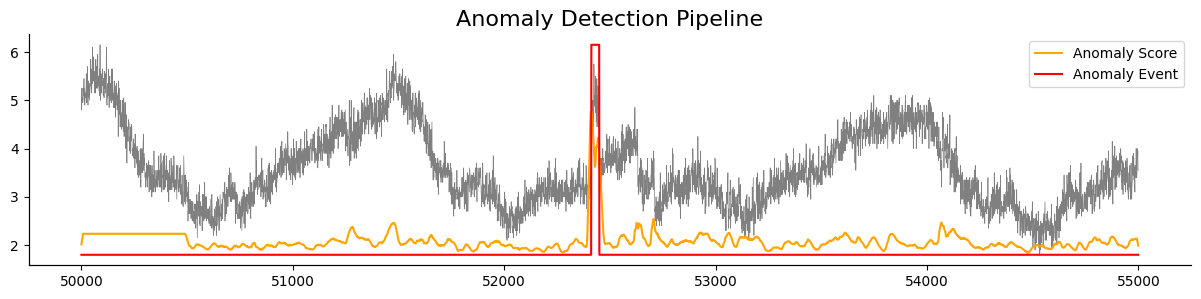

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax2 = ax.twinx()
result.x.plot(ax=ax, color="gray", linewidth=0.5)
result.anomaly_score.plot(ax=ax2, color="orange", label="Anomaly Score")
result.y.plot(ax=ax2, color="red", label="Anomaly Event")
ax2.legend()
ax2.set_yticks([])
ax.set_title("Anomaly Detection Pipeline", fontsize=16)
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)

In [10]:
result.head(5)

,x,y,timestamp,group,anomaly_score
50000,5.00,0,2022-01-01 00:00:00,0,0.049969
50001,4.80,0,2022-01-01 00:00:01,0,0.056215
50002,5.25,0,2022-01-01 00:00:02,0,0.062462
50003,4.95,0,2022-01-01 00:00:03,0,0.068708
50004,5.05,0,2022-01-01 00:00:04,0,0.074954


## Threshold Based Anomaly Marking

In [11]:
anomaly_threshold = 0.4
result["detections"] = (result["anomaly_score"] > anomaly_threshold).astype(float)

result.head()

,x,y,timestamp,group,anomaly_score,detections
50000,5.00,0,2022-01-01 00:00:00,0,0.049969,0.0
50001,4.80,0,2022-01-01 00:00:01,0,0.056215,0.0
50002,5.25,0,2022-01-01 00:00:02,0,0.062462,0.0
50003,4.95,0,2022-01-01 00:00:03,0,0.068708,0.0
50004,5.05,0,2022-01-01 00:00:04,0,0.074954,0.0


## Computing F1 Score for detection

In [12]:
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score


matrix = confusion_matrix(result["y"].values, result["detections"].values)
matrix = pd.DataFrame(
    matrix,
    columns=["Predicted Anomaly: No", "Predicted Anomaly: Yes"],
    index=["True Anomaly: No", "True Anomaly: Yes"],
)

f_score = f1_score(result["y"].values, result["detections"].values, average="binary")

display(f"F1 score: {f_score:.2f}")
display(matrix)

'F1 score: 0.85'

,Predicted Anomaly: No,Predicted Anomaly: Yes
True Anomaly: No,4949,13
True Anomaly: Yes,0,38
